In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import statsmodels.api as sm
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#데이터 불러오기

In [ ]:
%cd /content/drive/MyDrive/Caba2012/cakd1_project/p3_2

/content/drive/.shortcut-targets-by-id/1DgqCdGjH-Do4g1EBoj-rVW9AGMQvVxQ-/Caba2012/cakd1_project/p3_2


In [ ]:
co_df = pd.read_csv('./Demo_최종_모델검증.csv' ,encoding='CP949')
co_df

,ORDERID,SOLDDATE,CUSTID,PRODID,PRODNAME,WEEKDAY,SITEBUSNAME,REGION,D_DAY_2_TEM,D_DAY_2_HUM,D_DAY_2_WIND,D_DAY_2_TEM_RAINAMOUNT,D_DAY_2_RAINHOUR,ORDER_QUANT,SOLD_QUANT
0,AE21030434,2021-03-07,2007400,SSA013035307,AE,목,삼표,풍납,6.6,58.5,2.2,0.0,0.00,532,1000
1,HR1021030423,2021-03-07,2001500,PEMA363048300,PEMA-HR1000,목,제일,홍성,5.5,65.0,0.9,0.0,0.00,5184,6000
2,HR1021030426,2021-03-07,2001600,PEMA093001100,PEMA-HR1000,목,동해,동해,8.1,62.1,2.1,0.0,0.00,10032,8000
3,HR1021030427,2021-03-07,2001700,PEMA093001100,PEMA-HR1000,목,동해,동해,8.1,62.1,2.1,0.0,0.00,1344,2000
4,HR1521030432,2021-03-07,2002800,PEMA053046500,PEMA-HR1500,목,신일,송파,6.6,58.5,2.2,0.0,0.00,6260,5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24211,HR1021032444_210127,2021-01-30,2002400,PEMA023024801,PEMA-HR1000,수,동진,수원,5.0,89.0,2.2,1.7,5.08,3259,3650
24212,HR1521032423_210127,2021-01-30,2003100,PEMA013082100,PEMA-HR1500,수,대원씨앤엠,울산,10.6,75.9,2.5,12.1,8.25,11563,10950
24213,AE21032452_210127,2021-01-30,2006606,SSA073046500,AE,수,신일,송파,5.0,74.5,2.7,0.7,0.83,1892,1460
24214,HR1021032428_210127,2021-01-30,2001400,PEMA013128300,PEMA-HR1000,수,경연,원주,5.0,75.6,1.2,1.9,0.00,1682,1460


#컬럼명 변경

In [ ]:
co_df.rename(columns={'SOLDDATE': 'Requested_Date'}, inplace=True)
co_df.rename(columns={'ORDERID': 'Order_Number' , 'SOLD_QUANT':'Requested_Quantity'}, inplace=True)
co_df.head()

,Order_Number,Requested_Date,CUSTID,PRODID,PRODNAME,WEEKDAY,SITEBUSNAME,REGION,D_DAY_2_TEM,D_DAY_2_HUM,D_DAY_2_WIND,D_DAY_2_TEM_RAINAMOUNT,D_DAY_2_RAINHOUR,ORDER_QUANT,Requested_Quantity
0,AE21030434,2021-03-07,2007400,SSA013035307,AE,목,삼표,풍납,6.6,58.5,2.2,0.0,0.0,532,1000
1,HR1021030423,2021-03-07,2001500,PEMA363048300,PEMA-HR1000,목,제일,홍성,5.5,65.0,0.9,0.0,0.0,5184,6000
2,HR1021030426,2021-03-07,2001600,PEMA093001100,PEMA-HR1000,목,동해,동해,8.1,62.1,2.1,0.0,0.0,10032,8000
3,HR1021030427,2021-03-07,2001700,PEMA093001100,PEMA-HR1000,목,동해,동해,8.1,62.1,2.1,0.0,0.0,1344,2000
4,HR1521030432,2021-03-07,2002800,PEMA053046500,PEMA-HR1500,목,신일,송파,6.6,58.5,2.2,0.0,0.0,6260,5000


In [ ]:
# 시계열분석에 사용되는 칼럼만 추출
co_df = co_df[['Order_Number', 'PRODNAME','Requested_Quantity','Requested_Date']]

# datetime 타입으로 변환 
co_df['Requested_Date'] = pd.to_datetime(co_df['Requested_Date'])
co_df.head()

,Order_Number,PRODNAME,Requested_Quantity,Requested_Date
0,AE21030434,AE,1000,2021-03-07
1,HR1021030423,PEMA-HR1000,6000,2021-03-07
2,HR1021030426,PEMA-HR1000,8000,2021-03-07
3,HR1021030427,PEMA-HR1000,2000,2021-03-07
4,HR1521030432,PEMA-HR1500,5000,2021-03-07


#Nan 값 확인

In [ ]:
co_df.isnull().sum()

Order_Number          0
PRODNAME              0
Requested_Quantity    0
Requested_Date        0
dtype: int64

In [ ]:
df = co_df.copy()
df

,Order_Number,PRODNAME,Requested_Quantity,Requested_Date
0,AE21030434,AE,1000,2021-03-07
1,HR1021030423,PEMA-HR1000,6000,2021-03-07
2,HR1021030426,PEMA-HR1000,8000,2021-03-07
3,HR1021030427,PEMA-HR1000,2000,2021-03-07
4,HR1521030432,PEMA-HR1500,5000,2021-03-07
...,...,...,...,...
24211,HR1021032444_210127,PEMA-HR1000,3650,2021-01-30
24212,HR1521032423_210127,PEMA-HR1500,10950,2021-01-30
24213,AE21032452_210127,AE,1460,2021-01-30
24214,HR1021032428_210127,PEMA-HR1000,1460,2021-01-30


In [ ]:
#주단위로 묶으면 데이터 맨 첫부분, 맨끝부분의 데이터가 적기때문에 처리

co_df = df[(df['Requested_Date'] < '2021-04-05')&(df['Requested_Date'] >= '2018')]

#제품별 시계열 분석 및 예측

In [ ]:
# 제품으로 묶기
co_df_part = co_df.loc[co_df["PRODNAME"]=="PEMA-HR1000"]
co_df_part

,Order_Number,PRODNAME,Requested_Quantity,Requested_Date
1,HR1021030423,PEMA-HR1000,6000,2021-03-07
2,HR1021030426,PEMA-HR1000,8000,2021-03-07
3,HR1021030427,PEMA-HR1000,2000,2021-03-07
11,HR1021030429,PEMA-HR1000,10000,2021-03-07
16,HR1021030440,PEMA-HR1000,10000,2021-03-07
...,...,...,...,...
24206,HR1021032419_210127,PEMA-HR1000,7300,2021-01-30
24209,HR1021032408_210127,PEMA-HR1000,7300,2021-01-30
24211,HR1021032444_210127,PEMA-HR1000,3650,2021-01-30
24214,HR1021032428_210127,PEMA-HR1000,1460,2021-01-30


In [ ]:
#(PEMA-CR1000부터 차분 0로 변경) 제품별 수주발생건수 비교
co_df.groupby('PRODNAME')['Requested_Quantity'].count().sort_values(ascending=False)

PRODNAME
PEMA-HR1000      8454
CSA5000          3397
PEMA-HR1500      3113
PEMA-SR2000      1668
PEMA-PR1000      1226
PEMA-SR3000F     1175
PEMA-580FX        753
AE                694
PEMA-PR2000       488
PEMA-PCM2000      457
PEMA-500FR        456
PEMA-SN400        438
CSA4000           313
PEMA-PCM2000B     252
PEMA-SR2000A      238
PEMA-CR1000       128
PEMA-PCR3000E      94
PEMA-SP1000        64
PR1000             48
PEMA-CSA5000       47
PEMA-SR5000F       47
PEMA-PCR3000N      32
CSA4000(PCA)       16
SRE-200            16
PEMA-HR1000S       15
SRE-110            15
PEMA-SPR           15
Name: Requested_Quantity, dtype: int64

In [ ]:
co_df_part_1 = co_df_part.copy()
co_df_part_1

,Order_Number,PRODNAME,Requested_Quantity,Requested_Date
1,HR1021030423,PEMA-HR1000,6000,2021-03-07
2,HR1021030426,PEMA-HR1000,8000,2021-03-07
3,HR1021030427,PEMA-HR1000,2000,2021-03-07
11,HR1021030429,PEMA-HR1000,10000,2021-03-07
16,HR1021030440,PEMA-HR1000,10000,2021-03-07
...,...,...,...,...
24206,HR1021032419_210127,PEMA-HR1000,7300,2021-01-30
24209,HR1021032408_210127,PEMA-HR1000,7300,2021-01-30
24211,HR1021032444_210127,PEMA-HR1000,3650,2021-01-30
24214,HR1021032428_210127,PEMA-HR1000,1460,2021-01-30


In [ ]:
# 시간을 인덱스로 set_index()
co_df_part_1 = co_df_part_1.set_index(["Requested_Date"])

# 주 단위로 자료의 수주량을 파악
- 일 단위로 분석하는것보다 효율적이고 정확도가 높다
- 월 단위로 하기에는 데이터 부족

In [ ]:
co_df_part_1_weekly = co_df_part_1.resample('W').sum()
co_df_part_1_weekly

,Requested_Quantity
Requested_Date,
2018-11-11,470080
2018-11-18,409760
2018-11-25,661440
2018-12-02,543920
2018-12-09,647675
...,...
2021-03-07,375640
2021-03-14,636000
2021-03-21,523000


In [ ]:
co_df_part_1_weekly.describe()

,Requested_Quantity
count,126.000000
mean,504701.388889
std,107685.971022
min,255510.000000
25%,415078.750000
50%,511373.500000
75%,579405.000000
max,722769.000000


#시간의 흐름에 따른 제품의 수주량(시각화) 

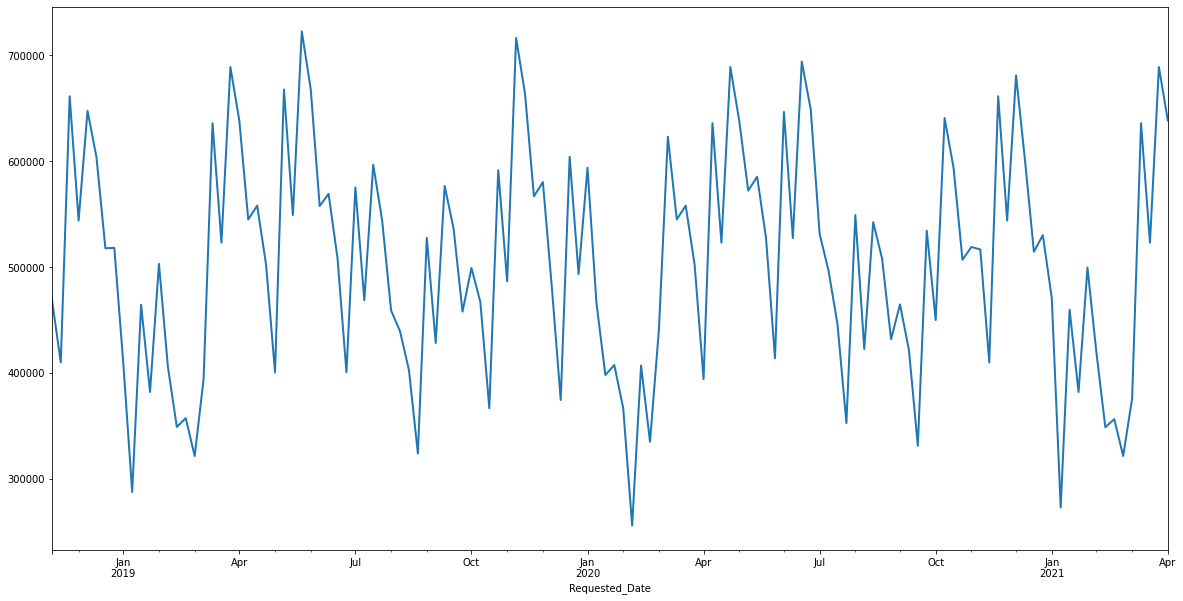

In [ ]:
co_df_part_1_weekly["Requested_Quantity"].plot(figsize = (20,10),linewidth=2)
# diff.plot(figsize = (20,10))

#모델링

##분해법

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

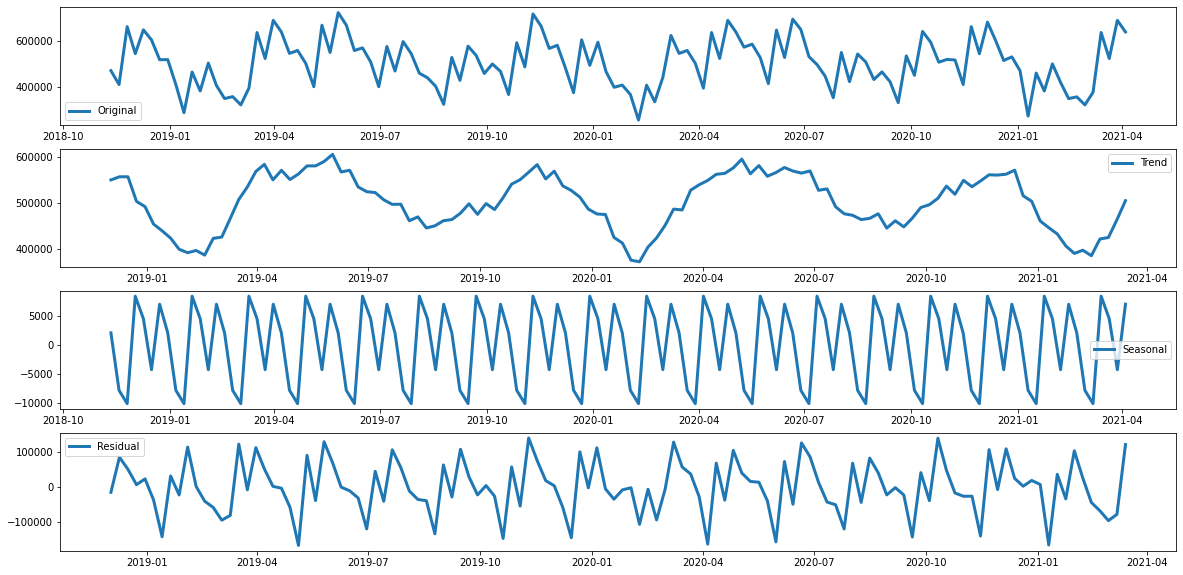

In [ ]:
# decomposition = seasonal_decompose(co_df_part_1_weekly["Requested_Quantity"])
decomposition = seasonal_decompose(co_df_part_1_weekly["Requested_Quantity"],model='addictive', freq=7)


trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(411)
ax2 = f.add_subplot(412)
ax3 = f.add_subplot(413)
ax4 = f.add_subplot(414)

ax2.plot(trend, label = 'Trend',linewidth=3)
ax2.legend(loc='best')

ax3.plot(seasonal, label = 'Seasonal',linewidth=3)
ax3.legend(loc='best')

ax4.plot(residual, label= 'Residual',linewidth=3)
ax4.legend(loc='best')

# ax4.plot(co_df_part_1_weekly.index, co_df_part_1_weekly['Requested_Quantity'], label= 'Original')
ax1.plot(co_df_part_1_weekly.index, co_df_part_1_weekly['Requested_Quantity'], label= 'Original',linewidth=3)

ax1.legend(loc='best')

### Verifying acf and pacf with seasonal difference
- 파라미터 값 찾기
- lag = 0은 무시
- acf, pacf그래프에서 lag가 급격히 낮아지거나, 천천히 낮아지는 등 그래프의 형태를 보고 판단
(일정한 규칙이 보이는 형태의 그래프의 경우 차분을 통해 정상성확보)

*자세한 설명 참조
https://www.statsmodels.org/dev/tsa.html

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

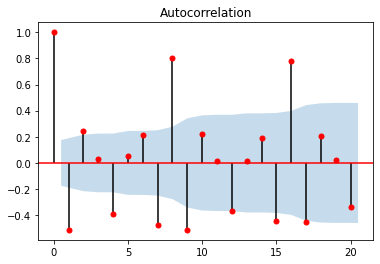

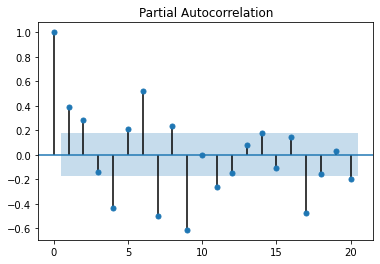

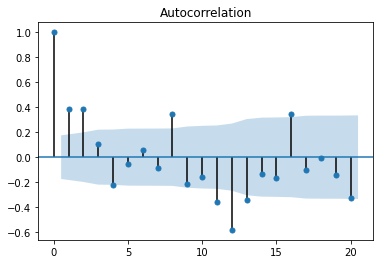

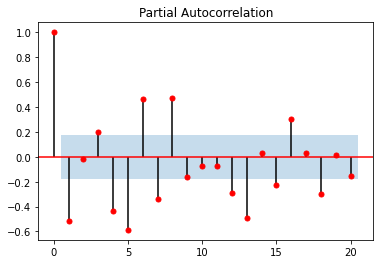

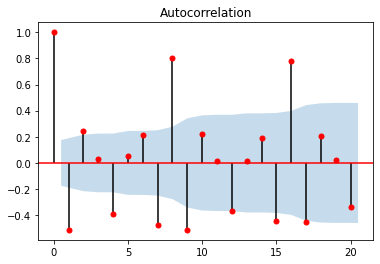

In [ ]:
# 빨강 = 차분 , 파랑 = 원래데이터
plot_pacf(co_df_part_1_weekly['Requested_Quantity'], lags=20)
plot_acf(co_df_part_1_weekly['Requested_Quantity'], lags=20)
diff = co_df_part_1_weekly['Requested_Quantity'].diff().dropna()
plot_pacf(diff, lags=20,color='r')
plot_acf(diff, lags=20,color='r')


In [ ]:
from statsmodels.tsa.stattools import adfuller

##AUTO_ARIMA

In [ ]:
import itertools

In [ ]:
# auto_arima를 위해 statsmodels, pmdarima 패키지 설치
!pip install pmdarima

In [ ]:
# 시간의 순서에 따라 train, test 데이터 분리(적절한 모델링과 평가를 위해 8:2 비율로 나눠줌)

train01 = co_df_part_1_weekly['Requested_Quantity'][:-24]
test01 = co_df_part_1_weekly['Requested_Quantity'][-24:]


In [ ]:
# # AUTO_ARIMA를 통해 best model 도출
# #원하는 범위 내의 파라미터를 지정해주면 AIC가 상대적으로 가장 낮은 모델을 선택해준다.

# from pmdarima import auto_arima

# auto_arima_model = auto_arima(train01, start_p = 1, start_q =1,
#                              max_p = 2 , max_q = 2, m = 12,
#                              start_P = 1,max_P =2 , start_Q = 1, max_Q = 2,
#                              seasonal = True, d = 1, D =1 , trace = True,
#                              error_action = 'ignore',
#                              suppress_warnings = True,
#                              stepwise = False)
# auto_arima_model.summary()

 ARIMA(0,1,0)(0,1,0)[12]             : AIC=2427.476, Time=0.02 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=2377.429, Time=0.08 sec
 ARIMA(0,1,0)(0,1,2)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=inf, Time=0.35 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=2301.567, Time=0.31 sec
 ARIMA(0,1,0)(1,1,2)[12]             : AIC=2264.916, Time=0.68 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=2267.912, Time=1.20 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=nan sec
 ARIMA(0,1,0)(2,1,2)[12]             : AIC=inf, Time=2.45 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=2417.060, Time=0.04 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2368.921, Time=0.14 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=2359.742, Time=0.45 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=2347.853, Time=0.22 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=2349.438, Time=0.45 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=2351.278, Time=0.78 sec
 ARIMA(0,1,1)(2,

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(1, 1, 2, 12)   Log Likelihood               -1128.458
Date:                            Mon, 31 May 2021   AIC                           2264.916
Time:                                    18:58:06   BIC                           2274.871
Sample:                                         0   HQIC                          2268.928
                                            - 102                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9449      0.049    -19.424      0.000      -1.040      -0.850
ma.S.L12      -0.2184      0.222     -0.986      0.324      -0.653       0.216
ma.S.L24      -0.3160      0.157     -2.008      0.045      -0.625      -0.008
sigma2      6.465e+09    3.9e-11   1.66e+20      0.000    6.47e+09    6.47e+09
===================================================================================
Ljung-Box (Q):                       52.58   Jarque-Bera (JB):               692.75
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                            -1.56
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.94e+36. Standard errors may be unstable.
"""

### 타임시리즈 분석 tsa¶
statsmodels.tsa에는 시계열 분석에 유용한 모델 클래스와 기능이 포함되어 있습니다. 기본 모델에는 단변형 자동 회귀 모델(AR), 벡터 자동 회귀 모델(VAR) 및 변변형 자동 회귀 이동 평균 모델(ARMA)이 포함됩니다. 비선형 모델에는 마르코프 스위칭 동적 회귀 및 자동 회귀가 포함됩니다. 또한 시계열에 대한 설명 통계(예: 자기 상관 관계, 부분 자기 상관 기능 및 주기전) 및 ARMA 또는 관련 프로세스의 해당 이론적 특성도 포함됩니다. 또한 자동 회귀 및 이동 평균 지연 다각형으로 작업하는 방법도 포함됩니다. 또한 관련 통계 테스트 및 유용한 도우미 기능을 사용할 수 있습니다.

In [ ]:
# 성능이 더 좋은 통계 분석 라이브러리를 import하여 best model의 파라미터값을 넣어줌
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
mod01 = sm.tsa.statespace.SARIMAX(train01,
                                order=(0,1,0),
                                seasonal_order=(1, 1, 1,12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results01 = mod01.fit()
print(results01.summary())

                                 Statespace Model Results                                 
Dep. Variable:                 Requested_Quantity   No. Observations:                  102
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 12)   Log Likelihood                -930.174
Date:                            Mon, 31 May 2021   AIC                           1866.347
Time:                                    18:58:06   BIC                           1873.340
Sample:                                11-11-2018   HQIC                          1869.142
                                     - 10-18-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.9556      0.036    -26.323      0.000      -1.027      -0.884
ma.S.L12      -0.0910      0.207   

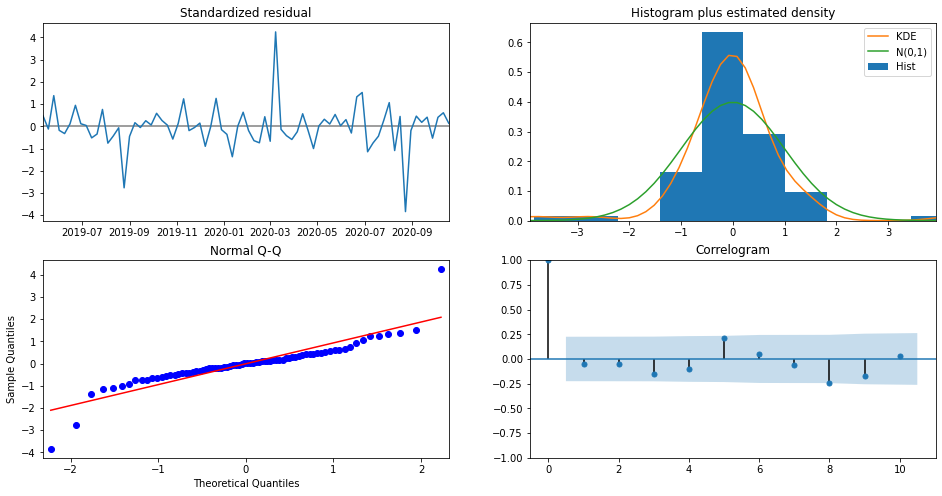

In [ ]:
#결과 시각화
results01.plot_diagnostics(figsize=(16, 8))
plt.show()

In [ ]:
# 결정계수 - 회귀모형의 설명력을 표현 
from sklearn.metrics import r2_score
prediction = results01.get_forecast(len(test01))
predicted_value1 = prediction.predicted_mean
predicted_ub = prediction.conf_int()['lower Requested_Quantity']
predicted_lb = prediction.conf_int()['upper Requested_Quantity']
predicted_index = list(test01.index)
r2 = r2_score(test01,predicted_value1)
r2

0.7377754258097964

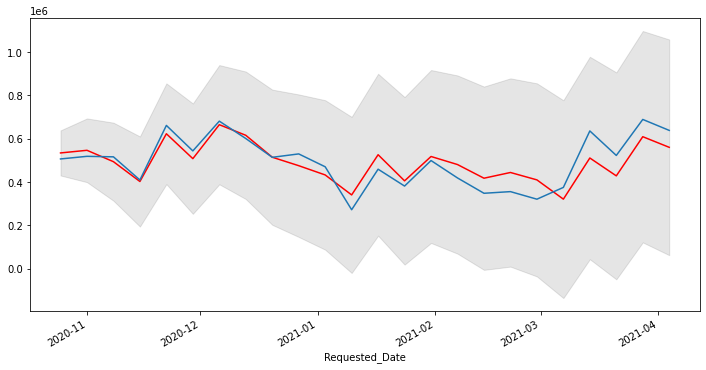

In [ ]:
#시각화
fig ,ax =plt.subplots(figsize=(12,6))
ax.plot(predicted_index, predicted_value1, color = 'red',label = 'Prediction')
ax.fill_between(predicted_index, predicted_lb, predicted_ub, color='k',alpha=0.1,
               label = '0.95 Prediction interval')

test01.plot(ax=ax)
plt.show()

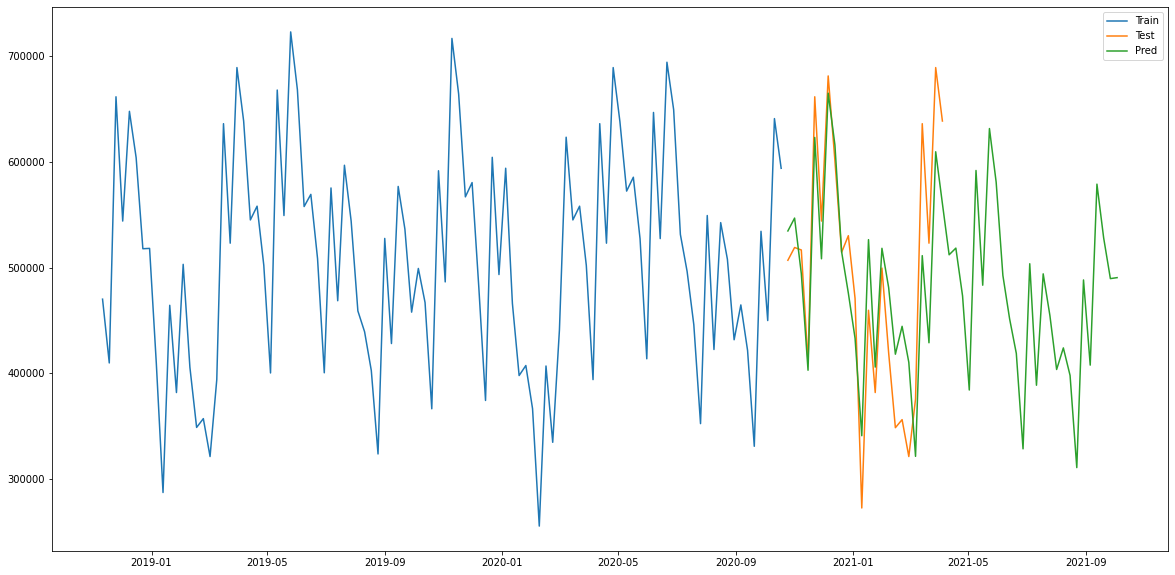

In [ ]:
#train 데이터를 학습하여 SARIMA로 예측한 pred값이 test와 얼마나 유사한지 그래프를 통해 비교

pred01 = results01.predict(start = test01.index[0], end = '2021-10', dynamic = True)
plt.figure(figsize = (20, 10))
plt.plot(train01.index, train01, label='Train')
plt.plot(test01.index, test01, label='Test')
plt.plot(pred01.index, pred01, label='Pred')
plt.legend(loc='best');



In [ ]:
Pred = pd.DataFrame(pred01,columns = ['Requested_Quantity'])
Pred

,Requested_Quantity
2020-10-25,534557.296288
2020-11-01,546739.132326
2020-11-08,494228.941641
2020-11-15,402858.885904
2020-11-22,622991.902218
2020-11-29,508256.508875
2020-12-06,664847.278227
2020-12-13,615944.834519
2020-12-20,514831.213151
2020-12-27,475785.504940


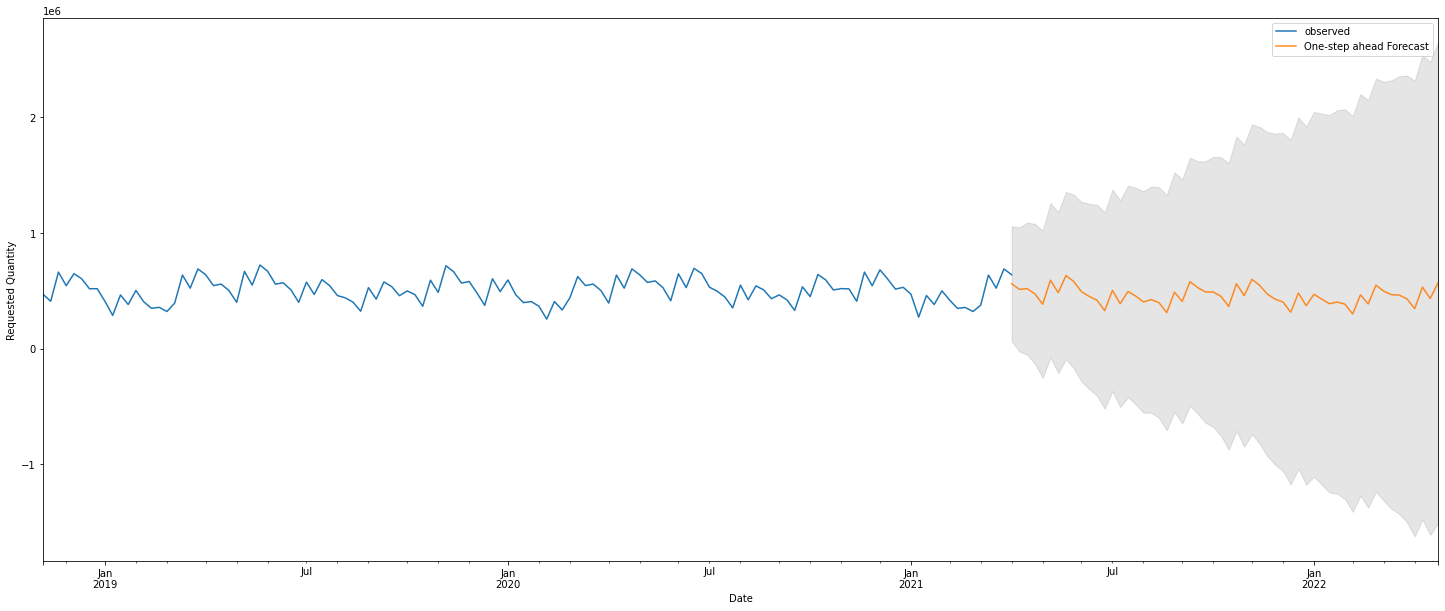

In [ ]:
pred001 = results01.get_prediction(start= 125, end = 180,  dynamic=True)
pred001_ci = pred001.conf_int()
ax = co_df_part_1_weekly.Requested_Quantity[:].plot(label='observed', figsize=(25,10))
pred001.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(25,10))
ax.fill_between(pred001_ci.index,
                pred001_ci.iloc[:, 0],
                pred001_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Requested Quantity')
plt.legend()
plt.show()

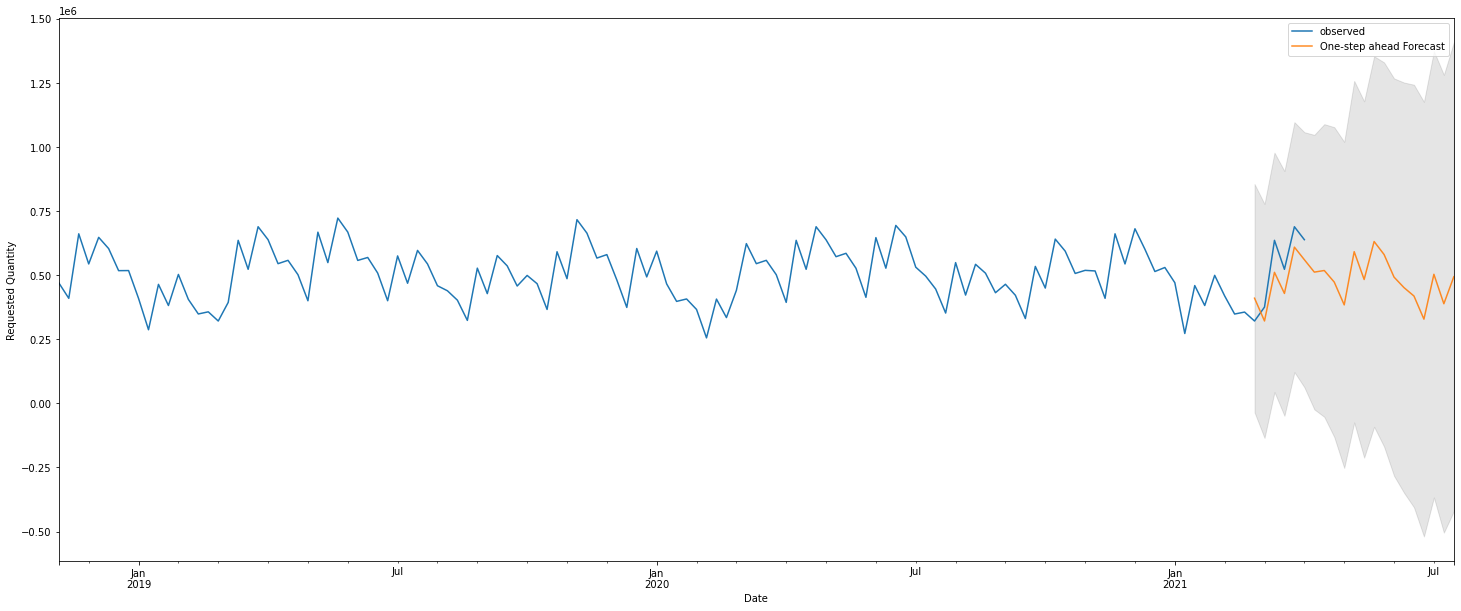

In [ ]:
pred = results01.get_prediction(start=120, end = 140, dynamic=True)
pred_ci = pred.conf_int()
ax = co_df_part_1_weekly.Requested_Quantity[:].plot(label='observed', figsize=(25,10))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.9, figsize=(25,10))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)
ax.set_xlabel('Date')
ax.set_ylabel('Requested Quantity')
plt.legend()
plt.show()

#예측값을 목적에 맞게 저장

In [ ]:
a = co_df_part['PRODNAME'].unique()
name = a[0]
name

'PEMA-HR1000'

In [ ]:
# 2021년 03월까지의 row_data
row = co_df_part_1_weekly[co_df_part_1_weekly.index < '2021-04']
row

,Requested_Quantity
Requested_Date,
2018-11-11,470080
2018-11-18,409760
2018-11-25,661440
2018-12-02,543920
2018-12-09,647675
...,...
2021-02-28,321280
2021-03-07,375640
2021-03-14,636000


In [ ]:
# 대시보드 시각화에 사용되는 데이터셋(kpi용)
part1 = df.loc[df["PRODNAME"]=="PEMA-HR1000"]
part1 = part1.set_index(['Requested_Date'])
part1_W = part1.resample('W').sum()
# part1_W= part1_W.reset_index
part2 = part1_W[part1_W.index >= '2021-04']
kpi = pd.DataFrame(part2)
kpi

,Requested_Quantity
Requested_Date,
2021-04-04,638500
2021-04-11,545000
2021-04-18,558000
2021-04-25,476000


In [ ]:
c = pd.DataFrame(row)
c['ispred'] = 0
c
d = pd.DataFrame(pred01,columns = ['Requested_Quantity'])
d['ispred'] = 1
d
f = pd.concat([c,d]).reset_index()
f.rename(columns = {'index':'Requested_Date'},inplace = True)
f['Part'] = name
kpi['Part'] = name
# v = pd.concat([f,kpi],axis=1)
v = pd.merge(f,kpi,on='Requested_Date',how='left')
v =v.fillna(0)
print(v[v['Requested_Quantity_y'] != 0])	
v

    Requested_Date  Requested_Quantity_x  ...  Requested_Quantity_y       Part_y
148     2021-04-04         560428.837034  ...              638500.0  PEMA-HR1000
149     2021-04-11         512039.873436  ...              545000.0  PEMA-HR1000
150     2021-04-18         518331.944515  ...              558000.0  PEMA-HR1000
151     2021-04-25         473137.829094  ...              476000.0  PEMA-HR1000

[4 rows x 6 columns]


,Requested_Date,Requested_Quantity_x,ispred,Part_x,Requested_Quantity_y,Part_y
0,2018-11-11,470080.000000,0,PEMA-HR1000,0.0,0
1,2018-11-18,409760.000000,0,PEMA-HR1000,0.0,0
2,2018-11-25,661440.000000,0,PEMA-HR1000,0.0,0
3,2018-12-02,543920.000000,0,PEMA-HR1000,0.0,0
4,2018-12-09,647675.000000,0,PEMA-HR1000,0.0,0
...,...,...,...,...,...,...
170,2021-09-05,407701.884115,1,PEMA-HR1000,0.0,0
171,2021-09-12,578828.306401,1,PEMA-HR1000,0.0,0
172,2021-09-19,527983.168606,1,PEMA-HR1000,0.0,0
173,2021-09-26,489510.402042,1,PEMA-HR1000,0.0,0


###수주정보를 담기위한 제품별 예측치 통합

In [ ]:
# d.rename(columns = {'index':'Requested_Date'},inplace = True)
# d['Part'] = name
# d

In [ ]:
# d.to_csv(f'./제품별 예측/{name}.csv')
# d.head()

In [ ]:
# #대시보드용 저장(kpi)
# v.to_csv(f'./대시보드/{name}.csv')
# v

In [ ]:
# #대시보드용 저장
# f.to_csv(f'./제품별 예측(21.04 - 21.10)/{name}.csv')
# f

In [ ]:
# # q = pd.read_csv(f'./제품별 예측/{s.index[0]}.csv', encoding='utf-8',index_col = 0)
# # q1 = pd.read_csv(f'./제품별 예측/{s.index[1]}.csv', encoding='utf-8',index_col = 0)
# # q2 = pd.read_csv(f'./제품별 예측/{s.index[2]}.csv', encoding='utf-8',index_col = 0)
# # q3 = pd.read_csv(f'./제품별 예측/{s.index[3]}.csv', encoding='utf-8',index_col = 0)
# # q4 = pd.read_csv(f'./제품별 예측/{s.index[4]}.csv', encoding='utf-8',index_col = 0)
# # q5 = pd.read_csv(f'./제품별 예측/{s.index[5]}.csv', encoding='utf-8',index_col = 0)
# # q6 = pd.read_csv(f'./제품별 예측/{s.index[6]}.csv', encoding='utf-8',index_col = 0)
# # q7 = pd.read_csv(f'./제품별 예측/{s.index[7]}.csv', encoding='utf-8',index_col = 0)
# # q8 = pd.read_csv(f'./제품별 예측/{s.index[8]}.csv', encoding='utf-8',index_col = 0)
# # q9 = pd.read_csv(f'./제품별 예측/{s.index[9]}.csv', encoding='utf-8',index_col = 0)
# # q10 = pd.read_csv(f'./제품별 예측/{s.index[10]}.csv', encoding='utf-8',index_col = 0)
# # q11 = pd.read_csv(f'./제품별 예측/{s.index[11]}.csv', encoding='utf-8',index_col = 0)
# # q12 = pd.read_csv(f'./제품별 예측/{s.index[12]}.csv', encoding='utf-8',index_col = 0)
# # q13 = pd.read_csv(f'./제품별 예측/{s.index[13]}.csv', encoding='utf-8',index_col = 0)
# # q14 = pd.read_csv(f'./제품별 예측/{s.index[14]}.csv', encoding='utf-8',index_col = 0)
# # q15 = pd.read_csv(f'./제품별 예측/{s.index[15]}.csv', encoding='utf-8',index_col = 0)
# # q16 = pd.read_csv(f'./제품별 예측/{s.index[16]}.csv', encoding='utf-8',index_col = 0)
# # q17 = pd.read_csv(f'./제품별 예측/{s.index[17]}.csv', encoding='utf-8',index_col = 0)
# # q18 = pd.read_csv(f'./제품별 예측/{s.index[18]}.csv', encoding='utf-8',index_col = 0)
# # q19 = pd.read_csv(f'./제품별 예측/{s.index[19]}.csv', encoding='utf-8',index_col = 0)
# # q20 = pd.read_csv(f'./제품별 예측/{s.index[20]}.csv', encoding='utf-8',index_col = 0)
# # q21 = pd.read_csv(f'./제품별 예측/{s.index[21]}.csv', encoding='utf-8',index_col = 0)
# # q22 = pd.read_csv(f'./제품별 예측/{s.index[22]}.csv', encoding='utf-8',index_col = 0)
# # q23 = pd.read_csv(f'./제품별 예측/{s.index[23]}.csv', encoding='utf-8',index_col = 0)
# # q24 = pd.read_csv(f'./제품별 예측/{s.index[24]}.csv', encoding='utf-8',index_col = 0)
# # q25 = pd.read_csv(f'./제품별 예측/{s.index[25]}.csv', encoding='utf-8',index_col = 0)
# # q26 = pd.read_csv(f'./제품별 예측/{s.index[26]}.csv', encoding='utf-8',index_col = 0)

# # # 대시보드용 
# # q = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[0]}.csv', encoding='utf-8',index_col = 0)
# # q1 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[1]}.csv', encoding='utf-8',index_col = 0)
# # q2 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[2]}.csv', encoding='utf-8',index_col = 0)
# # q3 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[3]}.csv', encoding='utf-8',index_col = 0)
# # q4 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[4]}.csv', encoding='utf-8',index_col = 0)
# # q5 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[5]}.csv', encoding='utf-8',index_col = 0)
# # q6 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[6]}.csv', encoding='utf-8',index_col = 0)
# # q7 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[7]}.csv', encoding='utf-8',index_col = 0)
# # q8 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[8]}.csv', encoding='utf-8',index_col = 0)
# # q9 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[9]}.csv', encoding='utf-8',index_col = 0)
# # q10 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[10]}.csv', encoding='utf-8',index_col = 0)
# # q11 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[11]}.csv', encoding='utf-8',index_col = 0)
# # q12 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[12]}.csv', encoding='utf-8',index_col = 0)
# # q13 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[13]}.csv', encoding='utf-8',index_col = 0)
# # q14 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[14]}.csv', encoding='utf-8',index_col = 0)
# # q15 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[15]}.csv', encoding='utf-8',index_col = 0)
# # q16 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[16]}.csv', encoding='utf-8',index_col = 0)
# # q17 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[17]}.csv', encoding='utf-8',index_col = 0)
# # q18 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[18]}.csv', encoding='utf-8',index_col = 0)
# # q19 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[19]}.csv', encoding='utf-8',index_col = 0)
# # q20 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[20]}.csv', encoding='utf-8',index_col = 0)
# # q21 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[21]}.csv', encoding='utf-8',index_col = 0)
# # q22 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[22]}.csv', encoding='utf-8',index_col = 0)
# # q23 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[23]}.csv', encoding='utf-8',index_col = 0)
# # q24 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[24]}.csv', encoding='utf-8',index_col = 0)
# # q25 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[25]}.csv', encoding='utf-8',index_col = 0)
# # q26 = pd.read_csv(f'./제품별 예측(21.04 - 21.10)/{s.index[26]}.csv', encoding='utf-8',index_col = 0)

# # 대시보드용 
# q = pd.read_csv(f'./대시보드/{s.index[0]}.csv', encoding='utf-8',index_col = 0)
# q1 = pd.read_csv(f'./대시보드/{s.index[1]}.csv', encoding='utf-8',index_col = 0)
# q2 = pd.read_csv(f'./대시보드/{s.index[2]}.csv', encoding='utf-8',index_col = 0)
# q3 = pd.read_csv(f'./대시보드/{s.index[3]}.csv', encoding='utf-8',index_col = 0)
# q4 = pd.read_csv(f'./대시보드/{s.index[4]}.csv', encoding='utf-8',index_col = 0)
# q5 = pd.read_csv(f'./대시보드/{s.index[5]}.csv', encoding='utf-8',index_col = 0)
# q6 = pd.read_csv(f'./대시보드/{s.index[6]}.csv', encoding='utf-8',index_col = 0)
# q7 = pd.read_csv(f'./대시보드/{s.index[7]}.csv', encoding='utf-8',index_col = 0)
# q8 = pd.read_csv(f'./대시보드/{s.index[8]}.csv', encoding='utf-8',index_col = 0)
# q9 = pd.read_csv(f'./대시보드/{s.index[9]}.csv', encoding='utf-8',index_col = 0)
# q10 = pd.read_csv(f'./대시보드/{s.index[10]}.csv', encoding='utf-8',index_col = 0)
# q11 = pd.read_csv(f'./대시보드/{s.index[11]}.csv', encoding='utf-8',index_col = 0)
# q12 = pd.read_csv(f'./대시보드/{s.index[12]}.csv', encoding='utf-8',index_col = 0)
# q13 = pd.read_csv(f'./대시보드/{s.index[13]}.csv', encoding='utf-8',index_col = 0)
# q14 = pd.read_csv(f'./대시보드/{s.index[14]}.csv', encoding='utf-8',index_col = 0)
# q15 = pd.read_csv(f'./대시보드/{s.index[15]}.csv', encoding='utf-8',index_col = 0)
# q16 = pd.read_csv(f'./대시보드/{s.index[16]}.csv', encoding='utf-8',index_col = 0)
# q17 = pd.read_csv(f'./대시보드/{s.index[17]}.csv', encoding='utf-8',index_col = 0)
# q18 = pd.read_csv(f'./대시보드/{s.index[18]}.csv', encoding='utf-8',index_col = 0)
# q19 = pd.read_csv(f'./대시보드/{s.index[19]}.csv', encoding='utf-8',index_col = 0)
# q20 = pd.read_csv(f'./대시보드/{s.index[20]}.csv', encoding='utf-8',index_col = 0)
# q21 = pd.read_csv(f'./대시보드/{s.index[21]}.csv', encoding='utf-8',index_col = 0)
# q22 = pd.read_csv(f'./대시보드/{s.index[22]}.csv', encoding='utf-8',index_col = 0)
# q23 = pd.read_csv(f'./대시보드/{s.index[23]}.csv', encoding='utf-8',index_col = 0)
# q24 = pd.read_csv(f'./대시보드/{s.index[24]}.csv', encoding='utf-8',index_col = 0)
# q25 = pd.read_csv(f'./대시보드/{s.index[25]}.csv', encoding='utf-8',index_col = 0)
# q26 = pd.read_csv(f'./대시보드/{s.index[26]}.csv', encoding='utf-8',index_col = 0)



In [ ]:
# e  = pd.concat([q,q1,q2,q3,q4,q5,q6,q7,q8,q9,q10,q11,q12,q13,q14,q15,q16,q17,q18,q19,q20,q21,q22,q23,q24,q25,q26])
# e


In [ ]:
# # # 모델활용용
# # e.to_csv(f'./제품별 예측/제품별 예측(21.04~21.10).csv')
# # 대시보드용
# e.to_csv(f'./대시보드/제품별 예측_kpi.csv')

In [ ]:
# s = co_df.groupby('PRODNAME')['Requested_Quantity'].count().sort_values(ascending=False)
# s

In [ ]:
# s

In [ ]:
3578/28

127.78571428571429